# Cats vs. Dogs - CNN Image Classifier

This notebook is my solution to the image classification coding challenge from [FreeCodeCamp "Machine Learning with Python"](https://www.freecodecamp.org/learn/machine-learning-with-python) course.

Here is my attempt to solve this assignment using Tensorflow and Keras.

## The Assignment

_"For this challenge, you will complete the code to classify images of dogs and cats. You will use TensorFlow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)_

_Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell._

_The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code._

_The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):_

```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

_You can tweak epochs and batch size if you like, but it is not required."_

## Building the Dataframes

In this section, we download the provided files and build the dataframes for training and testing de model. The provided data is already split in train/validation/test folders and each one has subfolders for cats and dogs: the two categories we have to work with.

Since the course is a bit outdated, it suggests you work with Tensorflow's __ImageDataGenerator__. Since this method is deprecated and not recommended anymore, we will use Keras' __image_dataset_from_directory__ for loading the images in the form of _tf.data.Dataframe_.

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Download project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# Extract zip and clean unwanted files
with ZipFile("cats_and_dogs.zip", "r") as zObject:
    zObject.extractall()

# Remove the remaining files we don't need
os.remove("cats_and_dogs.zip")
shutil.rmtree("__MACOSX")
PATH = "cats_and_dogs"

# Save directories for training, validation and test folders.
# Train/validation split is already done in the folder structure.
train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")
test_dir = os.path.join(PATH, "test")

In [ ]:
# Variables for pre-processing and training.
BATCH_SIZE = 32
EPOCHS = 30
IMG_HEIGHT = 250
IMG_WIDTH = 250

We build three different dataframes: one for training the model and one for validating each epoch results. The third one only has a few samples and is meant for manual testing at the end. The images will be packed in three _tf.data.Dataframe_ objects, with batching and automatic labels based in the folder structure.

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    shuffle=True,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=validation_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    shuffle=True,
)

# Note that the test dataset has shuffle=False so the list of predictions is always in the same order.
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels=None,
    batch_size=1,
    color_mode="rgb",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 1 classes.


## Building the Model

To perfom image classification of colour images, we have to build a __Convolutional Neural Network__. In this case, I made a simple one with the following architecture:

1. Rescaling layer
2. Multiple Data Augmentation layers
3. Multiple Conv2D -> MaxPool2D layers
4. Densely Connected classification layer

The final layer is a one-neuro Dense layer with sigmoid activation, that outputs a binary probability: dog or cat.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # This layer does the rescaling of pixel values from 0-255 to 0-1, so the neural network can handle 
    # values more efficiently. Note that resizing was already done when building the datasets.
    tf.keras.layers.Rescaling(scale=1./255),

    # This layers perform data augmentation: random rotations, zooms and flips to avoid overfitting.
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.3),
    tf.keras.layers.RandomZoom(height_factor=(0.0, 0.4)),

    # A series of convolution and maxpooling layers that filter and subsample the image repeatedly, 
    # attemping to find patterns, edges and shapes. The architecture is simple and offers decent 
    # results with low trial and error.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # This layers deactivates random inputs to neurons to avoid overfitting and "memorizing" data.
    tf.keras.layers.Dropout(0.3),

    # Densely connected layers that finishes in a one-neuron layer for classification.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 250, 250, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 250, 250, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                     

## Training and Testing the Model

Using the Adam optimizer, we quickly reach 70% validation accuracy after the 20th epoch. Further training could improve the results but, for this assignment, it's more than enough.

In [ ]:
# Training the model and storing the training data.
history = model.fit(
    train_dataset, epochs=EPOCHS, validation_data=validation_dataset, shuffle=True
)

Epoch 1/30
63/63 [==============================] - 21s 166ms/step - loss: 0.7278 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5110
Epoch 2/30
63/63 [==============================] - 10s 147ms/step - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 8s 128ms/step - loss: 0.6938 - accuracy: 0.5005 - val_loss: 0.6930 - val_accuracy: 0.5090
Epoch 4/30
63/63 [==============================] - 9s 133ms/step - loss: 0.6924 - accuracy: 0.5560 - val_loss: 0.6898 - val_accuracy: 0.5490
Epoch 5/30
63/63 [==============================] - 9s 135ms/step - loss: 0.6878 - accuracy: 0.5610 - val_loss: 0.7353 - val_accuracy: 0.5180
Epoch 6/30
63/63 [==============================] - 8s 128ms/step - loss: 0.6903 - accuracy: 0.5315 - val_loss: 0.6714 - val_accuracy: 0.6310
Epoch 7/30
63/63 [==============================] - 9s 132ms/step - loss: 0.6694 - accuracy: 0.6050 - val_loss: 0.6590 - val_accuracy: 0.6120
Epoc

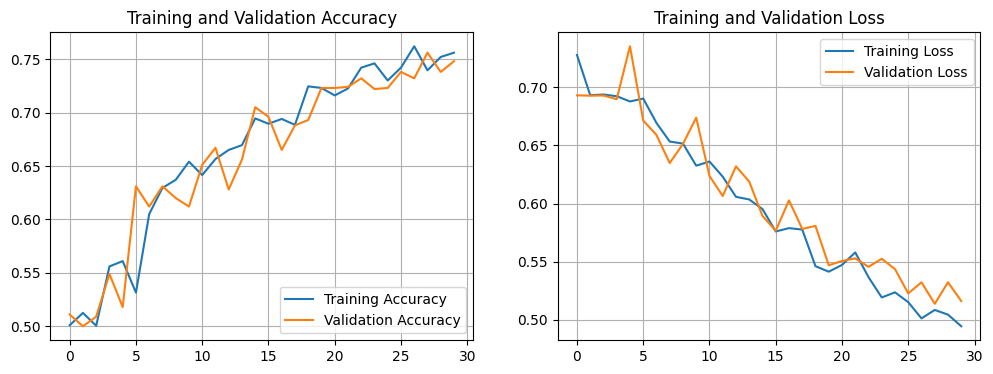

In [ ]:
# Plotting the training accuracy and loss.
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Final Evaluation

The 50 test images are used for making a list of predictions, and then the list is compared to the expected results. 60% accuracy is required to pass the assignment.

In [ ]:
# Generating a list of predictions using the test dataframe.
probabilities = model.predict(test_dataset)

50/50 [==============================] - 0s 2ms/step


In [ ]:
# This conversion is required because the assignment needs a 1D python list.
probabilities = probabilities.flatten().tolist()

answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
           1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
           1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
           0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {
      round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
